In [1]:
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List
from torch.utils.data import Dataset,DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32

In [6]:
tok = AutoTokenizer.from_pretrained('hf-internal-testing/tiny-random-distilbert')
model = AutoModel.from_pretrained('hf-internal-testing/tiny-random-distilbert')

Some weights of the model checkpoint at hf-internal-testing/tiny-random-distilbert were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'qa_outputs.weight', 'classifier.weight', 'pre_classifier.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'qa_outputs.bias', 'vocab_layer_norm.bias', 'classifier.bias', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
df = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv',
                 index_col=0)
mask = 1 - df.isna()
df.fillna(0, inplace=True)
# for col in df:
#   if df[col].dtype == 'int64':
#     df[col] = df[col].astype('int32')
#   if df[col].dtype == 'float64':
#     df[col] = df[col].astype('float32')
df = df.astype('float32')
mask = mask.astype('uint8')

In [8]:
xdf = df.iloc[:100]

In [9]:
print((1 - mask.mean().mean()) * 100, '% missing')

1.2499999999999956 % missing


In [10]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of 
    -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

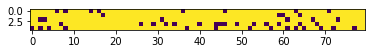

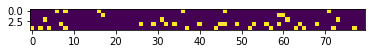

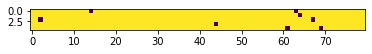

In [118]:
class MaskedTabularDataset(Dataset):
  def __init__(self, df:pd.DataFrame, mask:pd.DataFrame, 
               mask_rate: float = .1,
               validation=True
              ):
    self.data = torch.tensor(df.values, dtype=dtype)
    self.mask = torch.tensor(mask.values, dtype=torch.uint8)
    self.mask_rate = mask_rate
    self.validation = validation
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, indices) -> Tensor:
    dslice = self.data[indices]
    mslice = self.mask[indices]
    
    extra_mask = torch.rand(mslice.shape) > self.mask_rate
    train_targets = (extra_mask == 0) & (mslice != 0)
    train_mask = mslice * extra_mask
    
#     dslice = dslice.to(device)
#     train_mask = train_mask.to(device)
#     train_targets = train_targets.to(device)
    
    return dslice, train_mask, train_targets
d = MaskedTabularDataset(df, mask, mask_rate=.1)
x,y,z = d[:5]
plt.imshow(y)
plt.figure()
plt.imshow(z)
plt.figure()
plt.imshow(mask.iloc[:5].values)
assert x.shape == y.shape == x.shape == (5,80)
assert ((x - df.iloc[:5].values) == 0).all()
assert set(y.numpy().reshape(-1)) == {0., 1.}
assert set(z.numpy().ravel()) == {0, 1}
del d

In [119]:
NROWS = df.shape[0]
NCOLS = df.shape[1]

In [120]:
VALID_NROWS = NROWS // 100
TRAIN_NROWS = NROWS - VALID_NROWS

In [121]:
fullds = MaskedTabularDataset(df,mask, mask_rate=.1)
trainds, valds = utils.data.random_split(fullds, 
                                         [TRAIN_NROWS, VALID_NROWS])

In [122]:
BATCH_SIZE = 2 ** 15

In [123]:
traindl = DataLoader(trainds, 
                     shuffle=True,
                     num_workers=4,
                     pin_memory=True,
                     batch_size = BATCH_SIZE,)
valdl = DataLoader(valds, 
                  shuffle=False,
                  num_workers=4,
                  pin_memory=True,
                  batch_size = BATCH_SIZE * 2)

In [26]:
%%time
for i, batch in enumerate(traindl):
  if i > 10:
    break

CPU times: user 420 ms, sys: 231 ms, total: 651 ms
Wall time: 9.69 s


In [27]:
epochs = 5
for epoch in range(epochs):
  for i, batch in enumerate(traindl):
    data, train_mask, train_targets = batch
    break
  break

In [274]:
tab_embedding = nn.Linear(NCOLS, 32)

In [47]:
inp = torch.randint(0, 1000, (32, 40))
outp = model.embeddings(inp)
outp.shape

torch.Size([32, 40, 32])

In [63]:
inp = torch.randn(32, 40, 32)
# outp = model.transformer(inp)
type(model.transformer.layer[0].attention)

transformers.models.distilbert.modeling_distilbert.MultiHeadSelfAttention

In [68]:
import transformers
# type(model)
transformers.models.distilbert.modeling_distilbert.DistilBertModel??

In [132]:
bins = 1124

In [143]:
x = df.F_1_0

In [161]:
y = np.histogram(x,bins)
hist, bin_edges = y

In [172]:
c = torch.tensor([.9])
a = torch.randn(42,1)
a * c

tensor([[-0.3611],
        [ 0.8688],
        [-1.7247],
        [-0.8343],
        [-1.8300],
        [-0.7741],
        [ 0.2882],
        [ 0.6994],
        [ 0.8065],
        [ 1.7345],
        [ 0.9767],
        [-0.3214],
        [ 0.3081],
        [-0.1345],
        [-0.9280],
        [-1.9241],
        [ 0.6305],
        [-0.2968],
        [ 0.4976],
        [-0.3228],
        [ 0.7203],
        [-0.4218],
        [ 1.1047],
        [ 0.1777],
        [ 0.2742],
        [-0.4010],
        [-2.0651],
        [-0.7176],
        [-0.2215],
        [-0.4966],
        [-0.1796],
        [-0.2210],
        [-2.7739],
        [-1.1260],
        [-0.0460],
        [-0.5599],
        [-0.1131],
        [ 1.0634],
        [-2.0862],
        [-0.3766],
        [ 0.8247],
        [-1.5986]])

In [164]:
hist.

array([1, 0, 0, ..., 0, 0, 1])

In [117]:
# input_ids = torch.randint(0, 1000, (32, 40))
input_ids = torch.ones(32, 40).int()
attention_mask = torch.randint(-100,100, (32, 40))
outp= model(
  input_ids=input_ids,
  attention_mask=attention_mask,
  input_embeds=
  output_attentions = True,
  output_hidden_states = True,)
# [[k,v.shape,v.dtype] for k,v in outp.items()]
print('Last hiddne state shape', outp.last_hidden_state.shape)
print('Number of tfm layers + 1 for embed', len(outp.hidden_states)) # 
print(outp.hidden_states[0].shape)
print(outp.hidden_states[1].shape)
print('Attention shape', outp.attentions[0].shape)
print(len(outp.attentions)) # Number of tfm layers
outp.keys()

Last hiddne state shape torch.Size([32, 40, 32])
Number of tfm layers + 1 for embed 6
torch.Size([32, 40, 32])
torch.Size([32, 40, 32])
Attention shape torch.Size([32, 4, 40, 40])
5


odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])

In [110]:
model.transformer

Transformer(
  (layer): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadSelfAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (q_lin): Linear(in_features=32, out_features=32, bias=True)
        (k_lin): Linear(in_features=32, out_features=32, bias=True)
        (v_lin): Linear(in_features=32, out_features=32, bias=True)
        (out_lin): Linear(in_features=32, out_features=32, bias=True)
      )
      (sa_layer_norm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (ffn): FFN(
        (dropout): Dropout(p=0.1, inplace=False)
        (lin1): Linear(in_features=32, out_features=37, bias=True)
        (lin2): Linear(in_features=37, out_features=32, bias=True)
        (activation): GELUActivation()
      )
      (output_layer_norm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    )
    (1): TransformerBlock(
      (attention): MultiHeadSelfAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (q_lin): Linear(in_feature

In [109]:
model.config

DistilBertConfig {
  "_name_or_path": "hf-internal-testing/tiny-random-distilbert",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 32,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 37,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 4,
  "n_layers": 5,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.20.1",
  "vocab_size": 1124
}

In [ ]:
print(outp.attentions[0].shape)

In [66]:
import transformers
# transformers.models.distilbert.modeling_distilbert.MultiHeadSelfAttention??

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config: PretrainedConfig):
        super().__init__()

        self.n_heads = config.n_heads
        self.dim = config.dim
        self.dropout = nn.Dropout(p=config.attention_dropout)

        assert self.dim % self.n_heads == 0

        self.q_lin = nn.Linear(in_features=config.dim, out_features=config.dim)
        self.k_lin = nn.Linear(in_features=config.dim, out_features=config.dim)
        self.v_lin = nn.Linear(in_features=config.dim, out_features=config.dim)
        self.out_lin = nn.Linear(in_features=config.dim, out_features=config.dim)

        self.pruned_heads: Set[int] = set()

    def prune_heads(self, heads: List[int]):
        attention_head_size = self.dim // self.n_heads
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(heads, self.n_heads, attention_head_size, self.pruned_heads)
        # Prune linear layers
        self.q_lin = prune_linear_layer(self.q_lin, index)
        self.k_lin = prune_linear_layer(self.k_lin, index)
        self.v_lin = prune_linear_layer(self.v_lin, index)
        self.out_lin = prune_linear_layer(self.out_lin, index, dim=1)
        # Update hyper params
        self.n_heads = self.n_heads - len(heads)
        self.dim = attention_head_size * self.n_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, ...]:
        """
        Parameters:
            query: torch.tensor(bs, seq_length, dim)
            key: torch.tensor(bs, seq_length, dim)
            value: torch.tensor(bs, seq_length, dim)
            mask: torch.tensor(bs, seq_length)

        Returns:
            weights: torch.tensor(bs, n_heads, seq_length, seq_length) Attention weights context: torch.tensor(bs,
            seq_length, dim) Contextualized layer. Optional: only if `output_attentions=True`
        """
        bs, q_length, dim = query.size()
        k_length = key.size(1)
        # assert dim == self.dim, f'Dimensions do not match: {dim} input vs {self.dim} configured'
        # assert key.size() == value.size()

        dim_per_head = self.dim // self.n_heads

        mask_reshp = (bs, 1, 1, k_length)

        def shape(x: torch.Tensor) -> torch.Tensor:
            """separate heads"""
            return x.view(bs, -1, self.n_heads, dim_per_head).transpose(1, 2)

        def unshape(x: torch.Tensor) -> torch.Tensor:
            """group heads"""
            return x.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * dim_per_head)

        q = shape(self.q_lin(query))  # (bs, n_heads, q_length, dim_per_head)
        k = shape(self.k_lin(key))  # (bs, n_heads, k_length, dim_per_head)
        v = shape(self.v_lin(value))  # (bs, n_heads, k_length, dim_per_head)

        q = q / math.sqrt(dim_per_head)  # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, q_length, k_length)
        mask = (mask == 0).view(mask_reshp).expand_as(scores)  # (bs, n_heads, q_length, k_length)
        scores = scores.masked_fill(mask, torch.tensor(-float("inf")))  # (bs, n_heads, q_length, k_length)

        weights = nn.functional.softmax(scores, dim=-1)  # (bs, n_heads, q_length, k_length)
        weights = self.dropout(weights)  # (bs, n_heads, q_length, k_length)

        # Mask heads if we want to
        if head_mask is not None:
            weights = weights * head_mask

        context = torch.matmul(weights, v)  # (bs, n_heads, q_length, dim_per_head)
        context = unshape(context)  # (bs, q_length, dim)
        context = self.out_lin(context)  # (bs, q_length, dim)

        if output_attentions:
            return (context, weights)
        else:
            return (context,)

In [38]:
df.head(10000).describe()

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.013758,-0.003932,-0.001344,-0.004670,-0.006562,0.007233,0.012585,-0.067482,-0.001134,-0.016369,...,0.329664,-0.000261,0.341303,-0.075954,-0.093519,0.036682,0.481762,0.331615,0.356302,0.035026
std,0.997102,0.988180,0.997567,0.998424,1.001309,0.986299,0.988003,0.725900,0.986922,0.990663,...,2.343665,2.245500,2.352445,0.779142,0.804810,0.702525,4.944890,2.355556,2.325799,0.762687
min,-3.950721,-3.711339,-3.991924,-3.638016,-3.694782,-3.905969,-4.565901,-5.089877,-3.626006,-3.723700,...,-8.673384,-8.578391,-8.943967,-5.425965,-6.085913,-3.664145,-21.531364,-7.938445,-7.499790,-4.633961
25%,-0.652578,-0.677542,-0.667383,-0.678866,-0.680896,-0.655918,-0.634941,-0.489951,-0.642562,-0.693838,...,-1.258214,-1.515898,-1.187016,-0.509534,-0.571106,-0.374325,-2.826729,-1.265520,-1.234806,-0.389375
50%,0.000000,0.000000,0.000000,-0.002495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.246422,-0.021871,0.336847,0.005902,-0.021037,0.082862,0.052698,0.306506,0.279058,0.113757
75%,0.682723,0.665338,0.673367,0.666814,0.662352,0.659837,0.668754,0.445423,0.649196,0.652642,...,1.878507,1.434053,1.896544,0.463040,0.457446,0.520567,3.473531,1.908401,1.922133,0.555714
max,3.871386,3.582253,3.912949,3.595686,3.389098,3.536764,3.586039,1.885402,3.728087,4.757862,...,8.915140,8.586932,10.373207,2.282734,2.520878,2.195653,20.669884,8.588004,9.246682,2.212173


In [ ]:
model

In [ ]:
# nn.Embedding()

In [ ]:
epochs = 5
for epoch in range(epochs):
  for i, batch in enumerate(data):
    data, train_mask, train_targets = batch
    # data shape [batch_size, num_cols, embed_dim]
    # train_mask shape same as data, 0's and -infs
    #   0's at train-set data points, -inf for other split data points
    # train_targets shape same as data, 0's and 1's
    #   1's at data points which should influence train loss, 0's otherwise
    pred = model(data, train_mask)
    loss = criterion(data, train_targets)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), .5)
    optimizer.step()

In [ ]:
for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
  data, targets = get_batch(train_data, i)
  batch_size = data.size(0)
  if batch_size != bptt:
    src_mask = src_mask[:batch_size, :batch_size]
  output = model(data, src_mask)
  loss = criterion(output.view(-1, ntokens), targets)
  optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
  optimizer.step()

In [8]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(1124, 32, padding_idx=0)
    (position_embeddings): Embedding(512, 32)
    (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=32, out_features=32, bias=True)
          (k_lin): Linear(in_features=32, out_features=32, bias=True)
          (v_lin): Linear(in_features=32, out_features=32, bias=True)
          (out_lin): Linear(in_features=32, out_features=32, bias=True)
        )
        (sa_layer_norm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=32, out_features=37, bias=True)
          (lin2): Linear(in_features=37, o

In [30]:
# !pip install git+https://github.com/tornikeo/tab-transformer-pytorch

  Cloning https://github.com/tornikeo/tab-transformer-pytorch to /tmp/pip-req-build-cq_qjc8g
  Running command git clone -q https://github.com/tornikeo/tab-transformer-pytorch /tmp/pip-req-build-cq_qjc8g
  Resolved https://github.com/tornikeo/tab-transformer-pytorch to commit 10cedc26ba54273fafe9ba2e15c47877a6d7b35f
  Created wheel for tab-transformer-pytorch: filename=tab_transformer_pytorch-0.1.4-py3-none-any.whl size=4579 sha256=6e59ce7fedd45a1c8f9ce22a63cbd71bc9d5b2391d713ec70278e0d01b589d81
  Stored in directory: /tmp/pip-ephem-wheel-cache-bakx0yli/wheels/ea/d3/c1/b0003b87658c098a368fd6a003355be89412cbd2629d3985ec
Successfully built tab-transformer-pytorch


In [31]:
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer

cont_mean_std = torch.randn(10, 2)

model = TabTransformer(
    categories = (10, 5, 6, 5, 8),      # tuple containing the number of unique values within each category
    num_continuous = 10,                # number of continuous values
    dim = 32,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = 8,                          # heads, paper recommends 8
    attn_dropout = 0.1,                 # post-attention dropout
    ff_dropout = 0.1,                   # feed forward dropout
    mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)

x_categ = torch.randint(0, 5, (1, 5))     # category values, from 0 - max number of categories, in the order as passed into the constructor above
x_cont = torch.randn(1, 10)               # assume continuous values are already normalized individually

pred = model(x_categ, x_cont)

In [23]:
inp = torch.ones(32,1,dtype=torch.int32) + torch.arange(10)
outp = model(inp)


In [28]:
outp.last_hidden_state.shape

torch.Size([32, 10, 32])

In [29]:
inp.shape

torch.Size([32, 10])